In [15]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from numpy import pi,sqrt,exp,sin,cos,power
from numpy.fft import fft,ifft,fftshift,fft2,ifft2
#from scipy.special import i0,i1

In [31]:
BN=6
Lrelative = 1./16.

N = 2**BN
Ltotal=1.
dx=Ltotal/N
L = Ltotal*Lrelative

dx = L/N
sqdx = dx

In [32]:
X = np.fft.fftfreq(N) * Ltotal
RX,RY = np.meshgrid(X,X)
K = np.fft.fftfreq(N) * N
KX,KY = np.meshgrid(K,K)
K2 = KX*KX+KY*KY
X2 = RX*RX+RY*RY

In [33]:
def KernelFunctionFourier(k):
    
    return 4.*L**4*pi**3*k**2*exp(-2*pi**2*L**2*k**2)

def RadialSpecForce(k):
    
    return 2.*pi*k*KernelFunctionFourier(k)

In [34]:
kernel = (1.-.5*X2/L**2)*np.exp(-.5*X2/L/L) # exponential correlation function
kernel = sqrt( fft2(kernel) )
kernel[0,0] = 0.

In [35]:
# new time, new forcing
f0 = np.random.normal(size=(N,N)) * sqdx
f0 = kernel * fft2(f0)

In [36]:
# related to radial binned radial spectrum
AbsK = sqrt(K2)
# final results will be stored here
kmax = int(sqrt(2.)*(N//2))
numk = N # number of fourier shells
dk = (kmax-1.)/numk
kvals = np.arange(1.,kmax,dk)

# related to exhaustive search radial spectrum
KPairs = np.array([[ np.sqrt(ki**2 + kj**2) for ki in K ] for kj in K ])
KvalsAll = np.unique(KPairs)
KCount = np.array( [np.count_nonzero(KPairs == k) for k in KvalsAll ] )
KIndex = np.array( [[ np.where( KvalsAll == KPairs[i,j] )[0][0] for i in range(N)] for j in range(N)])

In [40]:
def CalcSpecRadialBins(v0):
# v0 in Fourier space

    Spec = np.zeros(numk)
    
    # i: loop over different shells in ||K||
    for i,ki in enumerate(np.arange(1.,kmax,dk)):

        shell = np.nonzero( (AbsK >= ki) & (AbsK < ki+dk) )

        Spec[i] += ki * np.mean( (np.abs(v0)**2)[shell] )
            
    return Spec


def CalcSpecRadialSearch(v0):
# v0 in Fourier space

    Spec  = np.zeros(len(KvalsAll))
    
    for i in range(N):
        for j in range(N):
            Spec[KIndex[i,j]] += KvalsAll[KIndex[i,j]] * np.abs(v0[i,j])**2
            
    Spec *= 1. / KCount
                            
    return Spec

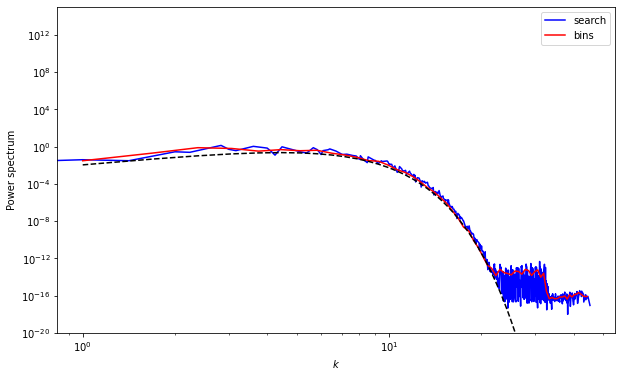

In [42]:
Spec1Bins = CalcSpecRadialBins(    f0 )
Spec1Srch = CalcSpecRadialSearch(  f0 )

fig, axs = plt.subplots(1,1,figsize=(10,6))

axs.plot(KvalsAll, Spec1Srch, color='b', label='search')
axs.plot(kvals, Spec1Bins, color='r', label='bins')
axs.plot(kvals, RadialSpecForce(kvals), color='k', linestyle='dashed')

axs.set_ylim((1e-20,1e15))
axs.set_ylabel(r'Power spectrum')
axs.set_xlabel(r'$k$')
axs.set_yscale('log')
axs.set_xscale('log')
plt.legend()
plt.show()

In [44]:
from scipy import interpolate

In [46]:
# 2d interpolation

f_real_interpolated = interpolate.interp2d(K, K, np.real(f0), kind='cubic')
f_imag_interpolated = interpolate.interp2d(K, K, np.imag(f0), kind='cubic')

In [49]:
f_real_interpolated((0.1,0.2))

TypeError: __call__() missing 1 required positional argument: 'y'